In [1]:
!pip install --upgrade numpy tensorflow pandas matplotlib scikit-learn

  Using cached numpy-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 38.6 MB/s eta 0:00:0000:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.9.3
    Uninstalling matplotlib-3.9.3:
      Successfully uninstalled matplotlib-3.9.3

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

2025-03-03 09:24:37.238979: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740993877.253668   11172 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740993877.258225   11172 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-03 09:24:37.276032: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
file_path = "mohler_dataset_edited.csv"  # Update with your actual path
df = pd.read_csv(file_path)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2273 entries, 0 to 2272
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2273 non-null   float64
 1   question        2273 non-null   object 
 2   desired_answer  2273 non-null   object 
 3   student_answer  2273 non-null   object 
 4   score_me        2273 non-null   float64
 5   score_other     2273 non-null   float64
 6   score_avg       2273 non-null   float64
dtypes: float64(4), object(3)
memory usage: 124.4+ KB


In [5]:
df['score'] = df['score_avg']

# Set maximum sequence lengths and vocabulary size
max_question_len = 100
max_desired_answer_len = 300
max_student_answer_len = 300
vocab_size = 10000

In [6]:
# Tokenize the texts
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(df['question'].tolist() + 
                       df['desired_answer'].tolist() + 
                       df['student_answer'].tolist())

# Convert text to sequences
question_sequences = tokenizer.texts_to_sequences(df['question'])
desired_answer_sequences = tokenizer.texts_to_sequences(df['desired_answer'])
student_answer_sequences = tokenizer.texts_to_sequences(df['student_answer'])

# Pad sequences
question_padded = pad_sequences(question_sequences, maxlen=max_question_len, padding='post')
desired_answer_padded = pad_sequences(desired_answer_sequences, maxlen=max_desired_answer_len, padding='post')
student_answer_padded = pad_sequences(student_answer_sequences, maxlen=max_student_answer_len, padding='post')


In [7]:
# Split the data
X_question_train, X_question_test, X_desired_train, X_desired_test, X_student_train, X_student_test, y_train, y_test = train_test_split(
    question_padded, desired_answer_padded, student_answer_padded, df['score'], test_size=0.2, random_state=42
)

In [8]:
# 2. Build the LSTM model
embedding_dim = 100

# Question input branch
question_input = Input(shape=(max_question_len,), name='question_input')
question_embedding = Embedding(vocab_size, embedding_dim)(question_input)
question_lstm = LSTM(64, return_sequences=False)(question_embedding)
question_dropout = Dropout(0.3)(question_lstm)

# Desired answer input branch
desired_input = Input(shape=(max_desired_answer_len,), name='desired_input')
desired_embedding = Embedding(vocab_size, embedding_dim)(desired_input)
desired_lstm = LSTM(64, return_sequences=False)(desired_embedding)
desired_dropout = Dropout(0.3)(desired_lstm)

# Student answer input branch
student_input = Input(shape=(max_student_answer_len,), name='student_input')
student_embedding = Embedding(vocab_size, embedding_dim)(student_input)
student_lstm = LSTM(64, return_sequences=False)(student_embedding)
student_dropout = Dropout(0.3)(student_lstm)

# Combine all features
merged = Concatenate()([question_dropout, desired_dropout, student_dropout])
dense1 = Dense(64, activation='relu')(merged)
dropout = Dropout(0.3)(dense1)
dense2 = Dense(32, activation='relu')(dropout)
output = Dense(1, activation='linear')(dense2)  # Linear for regression

# Define the model
model = Model(inputs=[question_input, desired_input, student_input], outputs=output)

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

2025-03-03 09:27:12.261468: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [9]:
# 3. Train the model
history = model.fit(
    [X_question_train, X_desired_train, X_student_train], 
    y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=32,
    verbose=1
)

Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 251ms/step - loss: 8.3211 - mae: 2.3869 - val_loss: 1.5661 - val_mae: 1.0799
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 248ms/step - loss: 1.6438 - mae: 1.0244 - val_loss: 1.5652 - val_mae: 1.0792
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 253ms/step - loss: 1.6684 - mae: 1.0401 - val_loss: 1.5144 - val_mae: 1.0286
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 241ms/step - loss: 1.4006 - mae: 0.9225 - val_loss: 1.5136 - val_mae: 1.0275
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 256ms/step - loss: 1.5756 - mae: 1.0086 - val_loss: 1.5219 - val_mae: 1.0386
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 236ms/step - loss: 1.5449 - mae: 1.0075 - val_loss: 1.5543 - val_mae: 1.0706
Epoch 7/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 236ms/step - loss: 1.3818 - mae: 0.9446 - val_loss: 1.7866 - val_mae: 1.1922
Epoch 8/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 239ms/step - loss: 1.4543 - mae: 0.9761 - val_loss: 1.4966 - val_mae: 0.9924
Epoch 9/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 240ms/

In [10]:
# 4. Evaluate the model
loss, mae = model.evaluate([X_question_test, X_desired_test, X_student_test], y_test)
print(f"Test Loss: {loss}")
print(f"Test MAE: {mae}")

# Make predictions
y_pred = model.predict([X_question_test, X_desired_test, X_student_test])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 1.5078 - mae: 1.1023
Test Loss: 1.4711934328079224
Test MAE: 1.0881736278533936
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step
RMSE: 1.2129276303016867


In [11]:
# 5. Save the model in .keras format
model.save('subjective_answer_evaluation.keras')

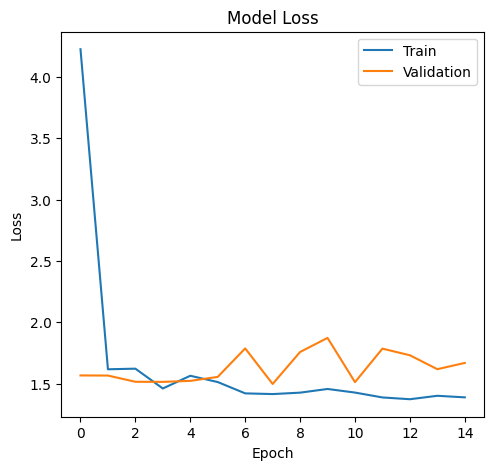

In [12]:
# 6. Visualize training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

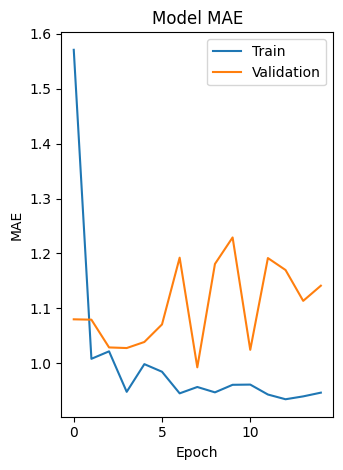

In [13]:
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

In [14]:
# 7. Function to predict scores for new answers
def predict_score(question, desired_answer, student_answer, tokenizer, model):
    # Preprocess the inputs
    question_seq = tokenizer.texts_to_sequences([question])
    desired_seq = tokenizer.texts_to_sequences([desired_answer])
    student_seq = tokenizer.texts_to_sequences([student_answer])
    
    question_padded = pad_sequences(question_seq, maxlen=max_question_len, padding='post')
    desired_padded = pad_sequences(desired_seq, maxlen=max_desired_answer_len, padding='post')
    student_padded = pad_sequences(student_seq, maxlen=max_student_answer_len, padding='post')
    
    # Make prediction
    prediction = model.predict([question_padded, desired_padded, student_padded])
    
    return prediction[0][0]

# Example usage
sample_question = "What is the significance of the American Civil War?"
sample_desired = "The American Civil War was significant because it ended slavery, preserved the Union, and led to major social and legal changes in the United States."
sample_student = "The Civil War ended slavery and kept the country together."

sample_score = predict_score(sample_question, sample_desired, sample_student, tokenizer, model)
print(f"Predicted score: {sample_score}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted score: 3.6466546058654785


In [15]:
# 8. Save the tokenizer for future use
import pickle
with open('answer_evaluation_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)